In [1]:
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from PIL import Image
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization

import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
#file_path = "C:\\Users\\alan\\Medical Image Project\\combine_data\\BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
file_path = "BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
text_data = pd.read_excel(file_path)
text_data.shape

(256, 21)

In [3]:
# filter out normal rows
filtered_text_data = text_data[(text_data['Classification'] == 'benign') | (text_data['Classification'] == 'malignant')]

# combine the relevant columns into a single text field per case
text_columns = [col for col in filtered_text_data.columns if col not in ['Image_filename', 'Classification', "Mask_tumor_filename","Mask_other_filename", "Pixel_size", "Verification","BIRADS"]]
filtered_text_data['combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

C:\Users\nickb\AppData\Local\Temp\ipykernel_5920\2840453312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_text_data['combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [4]:
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

text_inputs = processor(text=filtered_text_data["combined_text"].tolist(), padding=True, truncation=True, return_tensors="pt")

c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\nickb\anaconda3\envs\csc-752-final-project\lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless the

In [5]:
text_embeddings = model.get_text_features(**text_inputs)
text_embeddings.shape

torch.Size([252, 512])

In [6]:
# add label
labels = filtered_text_data['Classification'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Converts labels to numerical format

In [7]:
# split the data

# Convert it to a NumPy array
X = text_embeddings.detach().numpy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),                 # Dropout layer for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),         # BatchNormalization layer for normalization
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

Epoch 1/10
7/7 [==============================] - 1s 48ms/step - loss: 0.5456 - accuracy: 0.7065 - val_loss: 0.5526 - val_accuracy: 0.7647
Epoch 2/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2713 - accuracy: 0.9055 - val_loss: 0.4782 - val_accuracy: 0.9804
Epoch 3/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1756 - accuracy: 0.9403 - val_loss: 0.3910 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1297 - accuracy: 0.9652 - val_loss: 0.3237 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 6ms/step - loss: 0.0764 - accuracy: 0.9950 - val_loss: 0.2797 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 6ms/step - loss: 0.0622 - accuracy: 0.9851 - val_loss: 0.2454 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.2135 - val_accuracy: 1.0000
Epoch 8/10
7/7 [=================

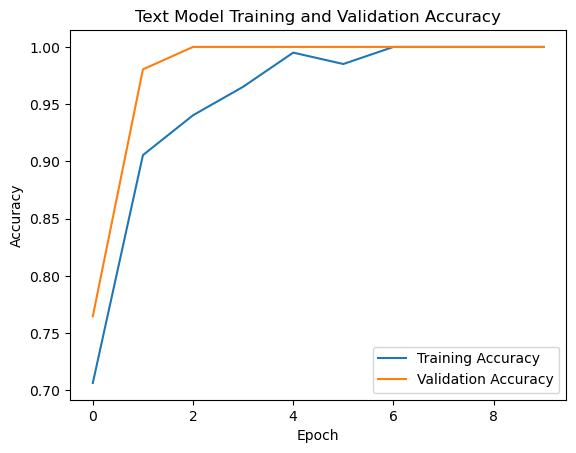

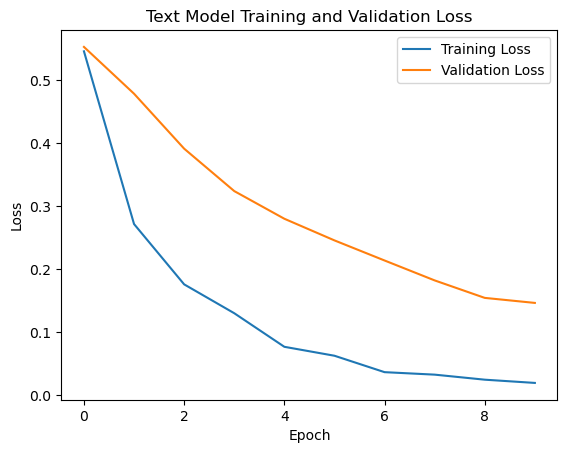

In [8]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Text Model Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Text Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
y_pred = model.predict(X_test).flatten()
y_pred = np.floor(y_pred+0.5)
# Rows are the ground truth, columns are what we predicted.
matrix = confusion_matrix(y_test, y_pred)
matrix

2/2 [==============================] - 0s 2ms/step


array([[35,  0],
       [ 0, 16]], dtype=int64)

In [18]:
tn = matrix[0][0]
tp = matrix[1][1]
fn = matrix[0][1]
fp = matrix[1][0]

In [20]:
precision = tp/(fp+tp)
recall = tp/(tp+fn)
f1 = precision*recall/(precision+recall)*2
f1

1.0